In [2]:
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
from scipy.optimize import curve_fit
from uncertainties import ufloat
from uncertainties import unumpy as unp
import array_to_latex as a2l
import csv
import pandas as pd
from astropy.io.votable import parse
from astropy.table import QTable, Table, Column

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']}) #font na grafih je LaTexov
rc('text', usetex=True)

In [4]:
def fja (x, A, B, C): 
    return A + B * x + C * np.sqrt(x)

94.18578546778163 8.86217398347945 6.71745126916404 1.6731316564838805 -11.568414579001555 2.4412614451487764


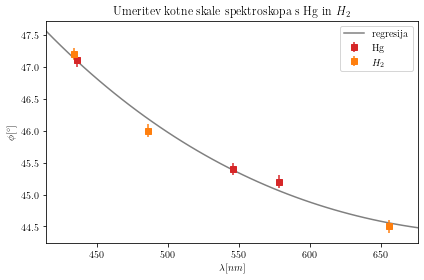

In [5]:
kot = unp.uarray([45.2, 45.4, 47.1, 44.5, 46.0, 47.2], 6 * [0.1])

dolz = unp.uarray([578, 546, 436, 656, 486, 434], 6 * [0]) * 1e-9

par, cov = curve_fit(fja, unp.nominal_values(dolz), unp.nominal_values(kot), sigma=unp.std_devs(kot), absolute_sigma=True)

A, B, C = par

dA, dB, dC = np.sqrt(np.diag(cov))

print(A, dA, B*1e-7, dB*1e-7, C*1e-4, dC*1e-4)

fig, ax = plt.subplots()

ax.errorbar(1e9 * unp.nominal_values(dolz)[:3], unp.nominal_values(kot)[:3], yerr=unp.std_devs(kot)[:3], color='tab:red', fmt='s', label="Hg")

ax.errorbar(1e9 * unp.nominal_values(dolz)[3:], unp.nominal_values(kot)[3:], yerr=unp.std_devs(kot)[3:], color='tab:orange', fmt='s', label='$H_2$')

dolz_lin = np.linspace(np.min(unp.nominal_values(dolz)) - 20e-9, np.max(unp.nominal_values(dolz)) +  20e-9)

ax.plot(1e9 * dolz_lin, fja(dolz_lin, A, B, C), color='grey', zorder=-1, label='regresija')

ax.set_title(r'Umeritev kotne skale spektroskopa s Hg in $H_2$')
ax.set_xlabel('$\lambda [nm]$')
ax.set_ylabel('$\phi [^{\circ}]$')
ax.set_xlim(1e9 * np.min(dolz_lin), 1e9 * np.max(dolz_lin))
ax.legend()
fig.tight_layout()
fig.savefig('kalibracija.pdf')

In [7]:
 from numba import vectorize

def makefunc_calc_dolz(A, B, C):
    @vectorize
    def calc_dolz(kot):
        return ((-C - np.sqrt(C**2 - 4*B*(A-kot))) / (2*B))**2
    return calc_dolz

calc_dolz = makefunc_calc_dolz(A, B, C)

In [8]:
import imageio.v2 as imageio

spectrum = imageio.imread('./sRGB-approx.png', pilmode='RGB')[0]

def colormap(dolz): 
    i = np.interp(dolz, [380e-9, 710e-9], [0, len(spectrum)]).astype(int)
    return spectrum[i]/255

\begin{array}
    47.3 &   425.8\\
    46.4 &   472.9\\
    45.8 &   512.2\\
    45.5 &   535.7\\
    45.2 &   563.3
\end{array}
None


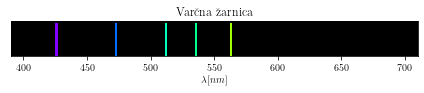

In [54]:
# varčna žarnica 

kot1 = np.array([47.3, 46.4, 45.8, 45.5, 45.2])

dolz = calc_dolz(kot1)

fig, ax = plt.subplots(1, 1, figsize=(6, 1.4))

ax.bar(1e9 * dolz, 1, width=2, color=colormap(dolz))

ax.set_title('Varčna žarnica')
ax.set_xlabel('$\lambda [nm]$')
ax.set_facecolor('k')
ax.set_xlim(390, 710)
ax.set_yticks([])
ax.set_yticklabels([])

fig.tight_layout()
fig.savefig('Vzarnica.pdf')

data = np.array([kot1, dolz * 1e9]).T

print(a2l.to_ltx(data, frmt='{:6.1f}', arraytype='array'))

[[ 47.1         46.         435.37861904 498.09568351]
 [ 45.4         45.1        544.3836605  573.82805493]
 [ 45.          44.7        585.17974115 627.28030799]
 [ 45.6         45.         527.49011839 585.17974115]]
\begin{array}
    47.1 &    46.0 &   435.4 &   498.1\\
    45.4 &    45.1 &   544.4 &   573.8\\
    45.0 &    44.7 &   585.2 &   627.3\\
    45.6 &    45.0 &   527.5 &   585.2
\end{array}
None


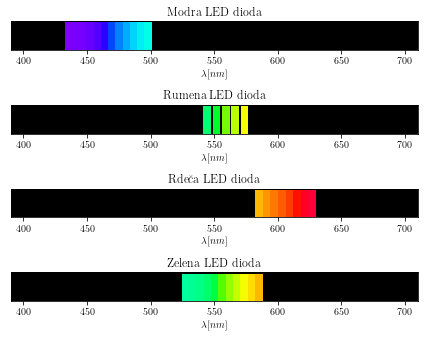

In [57]:
# LED 

kotmin = np.array([47.1, 45.4, 45.0, 45.6])

kotmax = np.array([46.0, 45.1, 44.7, 45.0])


dolzmin = calc_dolz(kotmin)

dolzmax = calc_dolz(kotmax)

data = np.array([kotmin, kotmax, dolzmin * 1e9, dolzmax * 1e9]).T


fig, axs = plt.subplots(4, 1, figsize=(6, 4 * 1.2))

aux = [
    ['Modra', 'Rumena', 'Rdeča', 'Zelena'], axs.flat, 
    np.stack([dolzmin, dolzmax], axis=1), 
    np.stack([kotmin, kotmax], axis=1)
]

for name, ax, (dolzmin, dolzmax), (kotmin, kotmax) in zip(*aux): 
    1e9 * calc_dolz(45.4)
    ddolz = 5e-9
    
    dolz_lin = np.linspace(dolzmin, dolzmax, int((dolzmax - dolzmin) / ddolz))

    for d in dolz_lin:
        ax.bar(1e9 * d, 1, width=1e9 * 1.2 * ddolz, color=colormap(d))

        ax.set_title(f'{name} LED dioda')
        ax.set_xlabel('$\lambda [nm]$')
        ax.set_facecolor('k')
        ax.set_xlim(390, 710)
        ax.set_yticks([])
        ax.set_yticklabels([])



fig.tight_layout()
fig.savefig('led.pdf')

print(a2l.to_ltx(data, frmt='{:6.1f}', arraytype='array'))

7.11746094959622e-07 6.460836267245875e-07
6.460836267245875e-07 5.535636327650585e-07
5.535636327650585e-07 4.85046544417216e-07
4.85046544417216e-07 4.2584237684249804e-07
4.2584237684249804e-07 3.8762079916541835e-07
544.383660503319


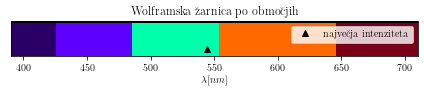

In [101]:
# Wolfram

kotmin = np.array([44.4, 44.6, 45.3, 46.2, 47.3])

kotmax = np.array([44.6, 45.3, 46.2, 47.3, 48.2])


dolzmin = calc_dolz(kotmin)

dolzmax = calc_dolz(kotmax)

data = np.array([kotmin, kotmax, dolzmin * 1e9, dolzmax * 1e9]).T


fig, axs = plt.subplots(1, 1, figsize=(6, 1.4))

axs.plot(1e9 * calc_dolz(45.4), 0.2, linestyle='', zorder=10, marker='^', color='k', label='največja intenziteta')


aux = [
    ['Modra', 'Rumena', 'Rdeča', 'Zelena', 'bla'], 
    np.stack([dolzmin, dolzmax], axis=1), 
    np.stack([kotmin, kotmax], axis=1)
]


for name, (dolzmin, dolzmax), (kotmin, kotmax) in zip(*aux):
    print(dolzmin, dolzmax) 
    d = (dolzmin + dolzmax) / 2
    dd = dolzmax - dolzmin
    axs.bar(1e9 * d, 1, width=1e9 * dd, color=colormap(d))


axs.set_title(r'Wolframska žarnica po območjih')
axs.set_xlabel('$\lambda [nm]$')
axs.set_facecolor('k')
axs.set_xlim(390, 710)
axs.legend()
axs.set_yticks([])
axs.set_yticklabels([])

1e9 * calc_dolz(45.4)
fig.tight_layout()
fig.savefig('wolfram.pdf')


print(1e9 * calc_dolz(45.4))

\begin{array}
    45.1 &   573.8\\
    45.3 &   553.6\\
    45.5 &   535.7\\
    45.8 &   512.2\\
    46.1 &   491.5\\
    46.3 &   478.9\\
    46.5 &   467.0\\
    46.7 &   455.9\\
    46.7 &   455.9
\end{array}
None


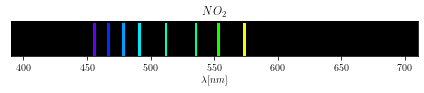

In [10]:
# no2

kot2 = np.array([45.1, 45.3, 45.5, 45.8, 46.1, 46.3, 46.5, 46.7, 46.7])

dolz = calc_dolz(kot2)

fig, ax = plt.subplots(1, 1, figsize=(6, 1.4))

ax.bar(1e9 * dolz, 1, width=2, color=colormap(dolz))

ax.set_title('$NO_2$')
ax.set_xlabel('$\lambda [nm]$')
ax.set_facecolor('k')
ax.set_xlim(390, 710)
ax.set_yticks([])
ax.set_yticklabels([])

fig.tight_layout()
fig.savefig('no2.pdf')

data = np.array([kot2, dolz*1e9]).T 

print(a2l.to_ltx(data, frmt='{:6.1f}', arraytype='array'))

\begin{array}
    44.5 &   670.3\\
    44.6 &   646.1\\
    45.1 &   573.8\\
    45.9 &   505.0\\
    46.0 &   498.1\\
    46.4 &   472.9\\
    46.8 &   450.6\\
    47.0 &   440.3
\end{array}
None


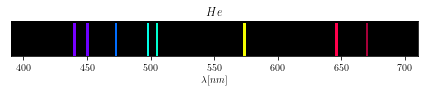

In [108]:
# he

kot3 = np.array([44.5, 44.6, 45.1, 45.9, 46.0, 46.4, 46.8, 47.0])

dolz = calc_dolz(kot3)

fig, ax = plt.subplots(1, 1, figsize=(6, 1.4))

ax.bar(1e9 * dolz, 1, width=2, color=colormap(dolz))

ax.set_title('$He$')
ax.set_xlabel('$\lambda [nm]$')
ax.set_facecolor('k')
ax.set_xlim(390, 710)
ax.set_yticks([])
ax.set_yticklabels([])

fig.tight_layout()
fig.savefig('He.pdf')

data = np.array([kot3, dolz * 1e9]).T

print(a2l.to_ltx(data, frmt='{:6.1f}', arraytype='array'))

\begin{array}
    45.0 &   585.2\\
    45.2 &   563.3\\
    45.4 &   544.4\\
    45.8 &   512.2\\
    46.7 &   455.9
\end{array}
None


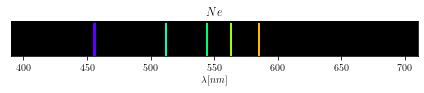

In [107]:
# he

kot4 = np.array([45.0, 45.2, 45.4, 45.8, 46.7])

dolz = calc_dolz(kot4)

fig, ax = plt.subplots(1, 1, figsize=(6, 1.4))

ax.bar(1e9 * dolz, 1, width=2, color=colormap(dolz))

ax.set_title('$Ne$')
ax.set_xlabel('$\lambda [nm]$')
ax.set_facecolor('k')
ax.set_xlim(390, 710)
ax.set_yticks([])
ax.set_yticklabels([])

fig.tight_layout()
fig.savefig('Ne.pdf')

data = np.array([kot4, dolz * 1e9]).T

print(a2l.to_ltx(data, frmt='{:6.1f}', arraytype='array'))